### read data (raw images)

In [6]:
from glob import glob

raw_image_files = glob('../data/*')
raw_image_files

['../data/kabir 2015.jpg',
 '../data/kabir 2017.jpg',
 '../data/DSC_4005.JPG',
 '../data/front.JPG',
 '../data/duke.jpg',
 '../data/mugshot1.JPG',
 '../data/puertomorelos.jpg',
 '../data/skype mugshot.JPG',
 '../data/mugshot2.jpg',
 '../data/DSC_3998.JPG',
 '../data/firstday.JPG',
 '../data/juggler.jpg',
 '../data/IMG_6096.JPG',
 '../data/back.JPG']

### create image embeddings

In [8]:
from sentence_transformers import SentenceTransformer, util, models

/home/vishal/code/demo-test/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# load the CLIP model
clip_model = models.CLIPModel()

model = SentenceTransformer(modules=[clip_model])

In [44]:
from PIL import Image

image_emb = []
raw_images = []
for raw_image_file in raw_image_files:
    raw_image = Image.open(raw_image_file)
    resized_image = raw_image.resize((224, 224))
    #image_emb.append(model.encode(raw_image, convert_to_tensor=True))
    raw_images.append(resized_image)
len(raw_images)

14

In [45]:
img_emb = model.encode(raw_images, batch_size=128, convert_to_tensor=True)

Batches: 100%|█████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


### cluster images

In [19]:
def community_detection(embeddings, threshold, min_community_size=10, init_max_size=1000):
    """
    Function for Fast Community Detection

    Finds in the embeddings all communities, i.e. embeddings that are close (closer than threshold).

    Returns only communities that are larger than min_community_size. The communities are returned
    in decreasing order. The first element in each list is the central point in the community.
    """

    # Compute cosine similarity scores
    cos_scores = util.cos_sim(embeddings, embeddings)

    # Minimum size for a community
    top_k_values, _ = cos_scores.topk(k=min_community_size, largest=True)

    # Filter for rows >= min_threshold
    extracted_communities = []
    for i in range(len(top_k_values)):
        if top_k_values[i][-1] >= threshold:
            new_cluster = []

            # Only check top k most similar entries
            top_val_large, top_idx_large = cos_scores[i].topk(k=init_max_size, largest=True)
            top_idx_large = top_idx_large.tolist()
            top_val_large = top_val_large.tolist()

            if top_val_large[-1] < threshold:
                for idx, val in zip(top_idx_large, top_val_large):
                    if val < threshold:
                        break

                    new_cluster.append(idx)
            else:
                # Iterate over all entries (slow)
                for idx, val in enumerate(cos_scores[i].tolist()):
                    if val >= threshold:
                        new_cluster.append(idx)

            extracted_communities.append(new_cluster)

    # Largest cluster first
    extracted_communities = sorted(extracted_communities, key=lambda x: len(x), reverse=True)

    # Step 2) Remove overlapping communities
    unique_communities = []
    extracted_ids = set()

    for community in extracted_communities:
        add_cluster = True
        for idx in community:
            if idx in extracted_ids:
                add_cluster = False
                break

        if add_cluster:
            unique_communities.append(community)
            for idx in community:
                extracted_ids.add(idx)

    return unique_communities

In [51]:
clusters = community_detection(img_emb, 
                               threshold=0.8,
                               min_community_size=2,
                               init_max_size=5)

print("Total number of clusters:", len(clusters))

Total number of clusters: 4


In [59]:
for cluster in clusters: 
    print(cluster)

[1, 0, 10]
[5, 12, 7]
[6, 9]
[8, 11]


### visualize clusters

0 [1, 0, 10]
1
0
10
1 [5, 12, 7]
5
12
7
2 [6, 9]
6
9
3 [8, 11]
8
11


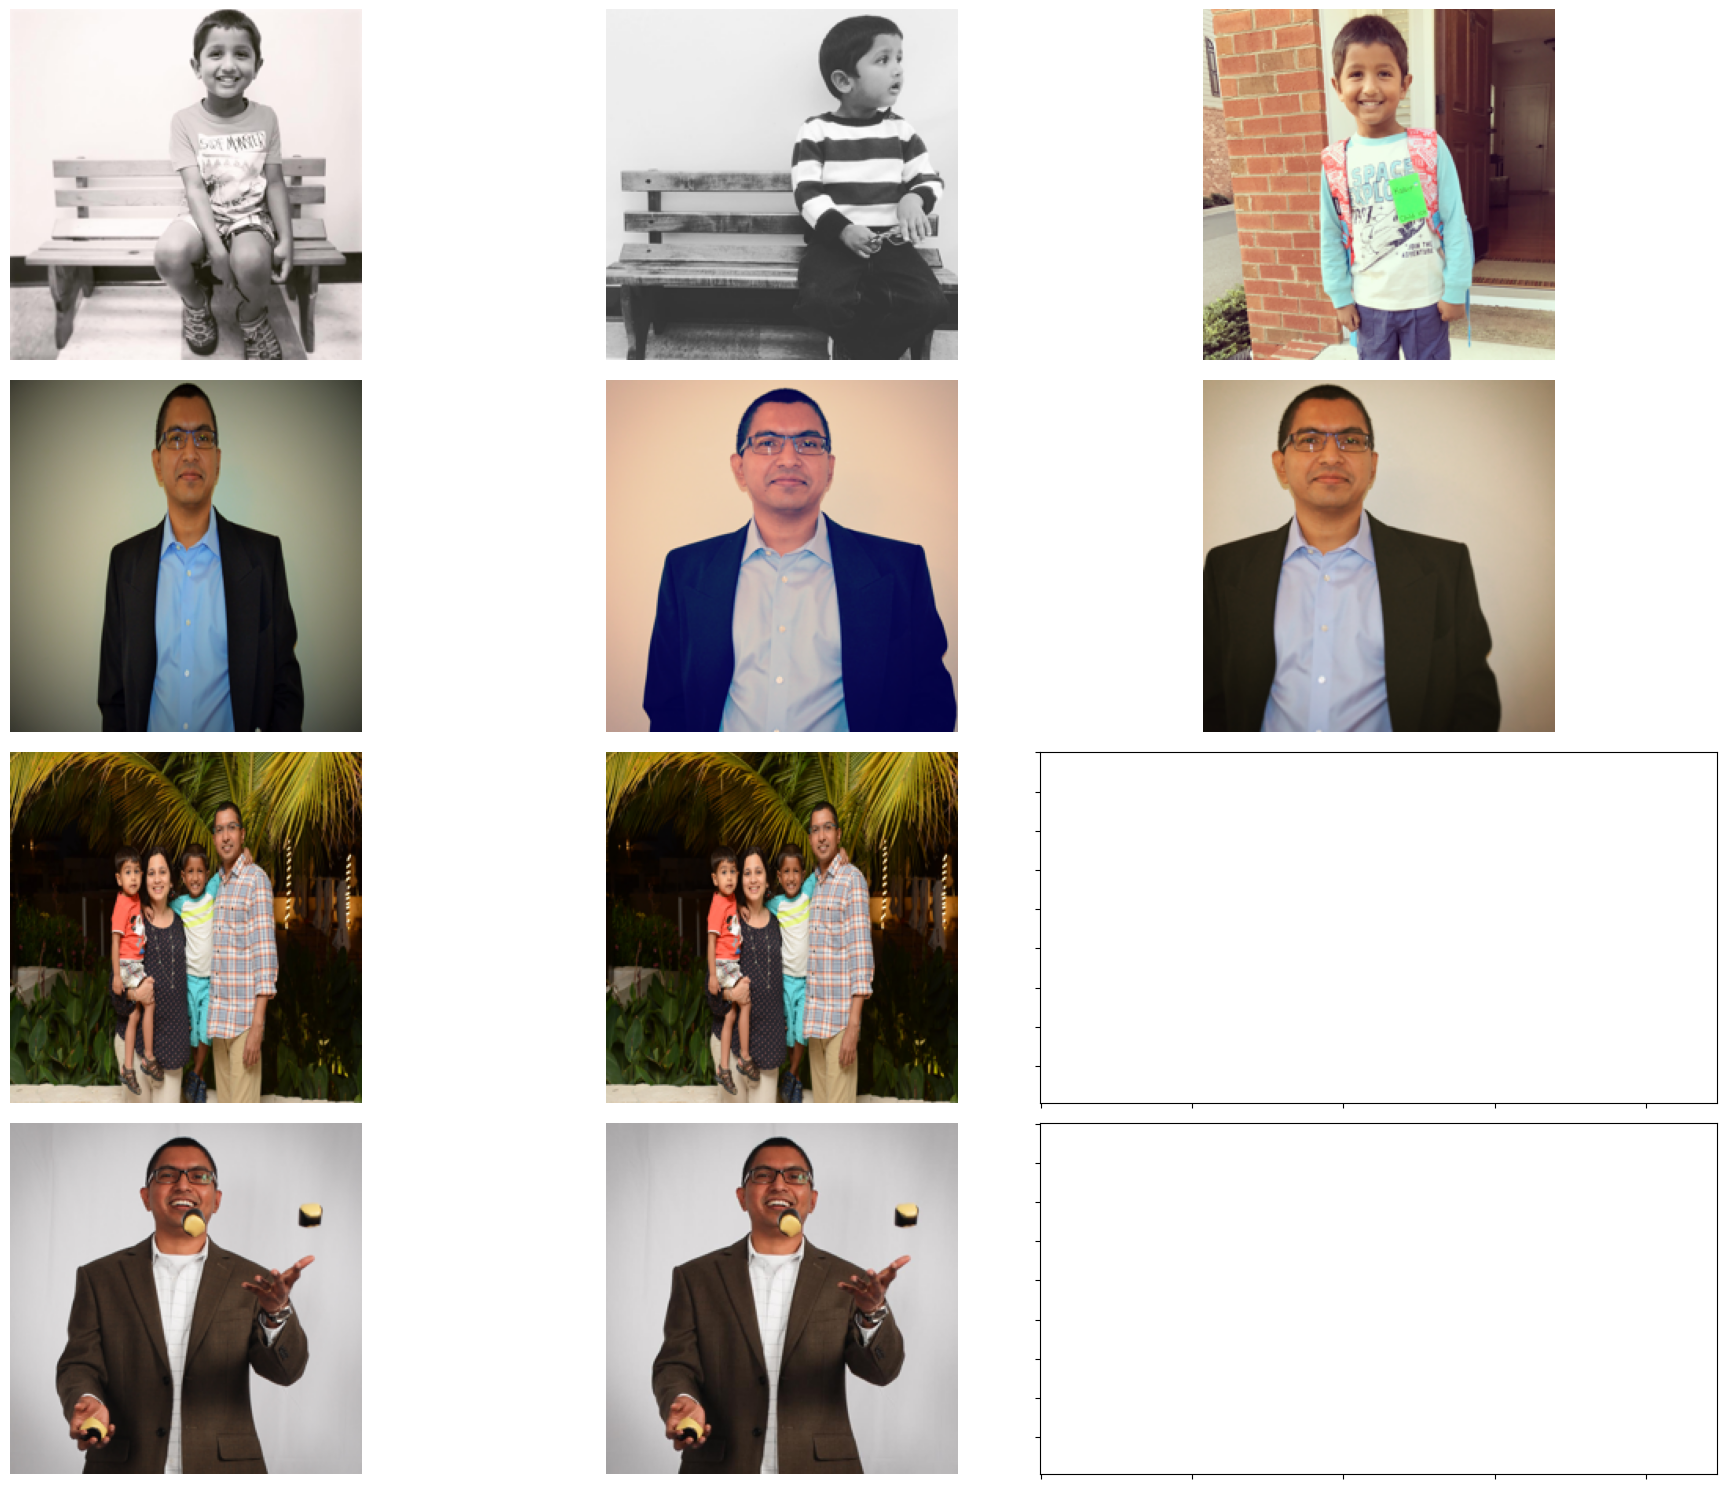

In [73]:
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(nrows=4, ncols=3, 
                         figsize=(19, 15), sharex=True, sharey=True)

for i, cluster in enumerate(clusters):
    print(i, cluster)
    for j, image_ind in enumerate(cluster):
        print(image_ind)
        ax = axes[i, j]
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.axis('off')
        ax.set_aspect('auto')
        ax.imshow(raw_images[image_ind])

plt.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()

In [80]:
image_ind = [i for cluster in clusters for i in cluster]
image_ind

[1, 0, 10, 5, 12, 7, 6, 9, 8, 11]